# car model

Let's start with some basic modeling, now that we actually have some data out of the way.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
from birdcall_distribution.geo import (
    get_shape_us_state,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    CA_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)

ee_df = pd.read_parquet("../data/earth_engine_v2.parquet")
grid_size = ee_df.grid_size.values[0]
ca_shape = get_shape_us_state("California")
grid = generate_grid(ca_shape, CA_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

In [17]:
from birdcall_distribution.utils import convert_time

df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df["hour"] = df.time.apply(convert_time)
df = df[["primary_label", "latitude", "longitude", "hour"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))
df

,primary_label,latitude,longitude,hour,grid_id,grid,adjacency_idx
51,amewig,35.0307,-120.6205,9.500000,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
56,amewig,32.5640,-117.1256,9.900000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
57,amewig,32.5640,-117.1256,10.250000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
58,amewig,32.5640,-117.1256,10.883333,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
59,amewig,32.5640,-117.1256,10.750000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
...,...,...,...,...,...,...,...
14652,wiltur,33.1349,-116.8522,10.850000,-117.5_32.75,"POLYGON ((-117.5 32.75, -116.75 32.75, -116.75...",22
14655,wiltur,35.2530,-120.8760,14.016667,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
14656,wiltur,32.8706,-116.4247,5.450000,-116.75_32.75,"POLYGON ((-116.75 32.75, -116 32.75, -116 33.5...",15
14660,wiltur,38.5321,-121.0686,5.633333,-121.25_38.0,"POLYGON ((-121.25 38, -120.5 38, -120.5 38.75,...",69


Now let's build our first model. We will create a logistic regression with CAR without any exogenous terms.
Our exogneous factors include landcover (which we will attempt to model as a categorical prior), temperature, and elevation.

In [18]:
# create counts for each adjacency index
import numpy as np
import pymc as pm
import arviz as az

In [19]:
from sklearn.preprocessing import StandardScaler

# count number of observed calls per adjacency index, and join against the ee variables
counts_df = df.grid_id.value_counts().reset_index()
counts_df.columns = ["grid_id", "y"]
prep_df = counts_df.merge(
    ee_df.rename(columns={"name": "grid_id"}), on="grid_id", how="outer"
)
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,grid_id,y,grid_size,total_pixels,elevation_mean,elevation_min,elevation_max,day_temp_mean,day_temp_min,day_temp_max,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,-114.5_32.75,4.0,0.75,5799,360.635686,42,1264,38.250063,28.135905,44.101721,...,0.000172,0.000860,0.053473,0.000516,0.019257,0.001204,0.000172,0.000172,0.245873,0.000688
1,-114.5_33.5,4.0,0.75,5810,332.958333,83,1060,38.373284,29.505644,42.446203,...,0.000172,0.000343,0.020079,0.000172,0.053887,0.002917,0.000172,0.000172,0.561009,0.000172
2,-114.5_34.25,15.0,0.75,5660,651.198508,125,2133,35.820667,21.121678,41.516905,...,0.000176,0.003523,0.046503,0.000176,0.000176,0.007574,0.000176,0.000176,0.147261,0.005461
3,-115.25_32.0,14.0,0.75,5797,27.443632,0,153,38.673146,28.443913,44.966025,...,0.000172,0.001204,0.024596,0.000172,0.394737,0.012900,0.000172,0.000172,0.466976,0.000688
4,-115.25_32.75,9.0,0.75,5795,212.048048,9,871,38.502550,31.003916,42.807535,...,0.000172,0.001893,0.041638,0.000172,0.041466,0.001721,0.000172,0.000172,0.755678,0.000344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,-124.25_40.25,24.0,0.75,5235,555.130669,-3,1749,18.493839,12.968095,25.919888,...,0.091584,0.015232,0.042079,0.003237,0.001523,0.009711,0.000190,0.000190,0.000571,0.045887
104,-124.25_41.0,NaN,0.75,5054,523.124211,0,1760,17.261679,10.346703,23.541750,...,0.016565,0.000986,0.002366,0.002761,0.000197,0.000789,0.000197,0.000197,0.000197,0.157365
105,-124.25_41.75,NaN,0.75,5135,685.691752,-3,2002,19.949706,11.934333,27.914494,...,0.067935,0.006599,0.014752,0.000194,0.000776,0.002329,0.000194,0.000194,0.000194,0.019992


In [20]:
# data_cols = [col for col in prep_df.columns if ("mean" in col) or ("land_cover" in col)]
data_cols = [col for col in prep_df.columns if ("mean" in col)]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)
scaled_data_df

,elevation_mean,day_temp_mean,night_temp_mean
0,-0.621457,1.623363,1.721511
1,-0.663885,1.642992,1.712087
2,-0.176039,1.236366,1.626217
3,-1.132225,1.690759,1.579366
4,-0.849235,1.663583,1.970668
...,...,...,...
103,-0.323306,-1.523754,-0.477840
104,-0.372370,-1.720034,-0.300435
105,-0.123162,-1.291838,-0.321815
106,-1.171066,-1.249057,0.036994


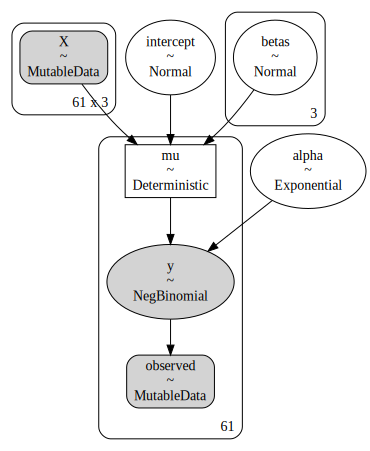

In [137]:
model_df = prep_df[prep_df.y.notnull()]

with pm.Model() as simple_model:
    # create a masked array with observed counts
    # observed = pm.ConstantData("observed", np.ma.masked_invalid(prep_df.y.values))
    observed = pm.MutableData("observed", model_df.y.values)
    # total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()].values)

    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, tau=1e-2)
    betas = pm.Normal("betas", mu=0, tau=1e-2, shape=X.shape[1])

    mu = pm.Deterministic("mu", pm.math.exp(intercept + pm.math.dot(X, betas)))
    pm.NegativeBinomial("y", mu=mu, alpha=alpha, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(simple_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, intercept, betas]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.234,0.162,1.934,2.548,0.002,0.001,6365.0,4774.0,1.0
betas[0],-0.777,0.243,-1.244,-0.333,0.003,0.002,5043.0,4723.0,1.0
betas[1],0.333,0.326,-0.317,0.919,0.005,0.003,5082.0,5371.0,1.0
betas[2],-0.268,0.345,-0.886,0.414,0.005,0.004,4324.0,4870.0,1.0


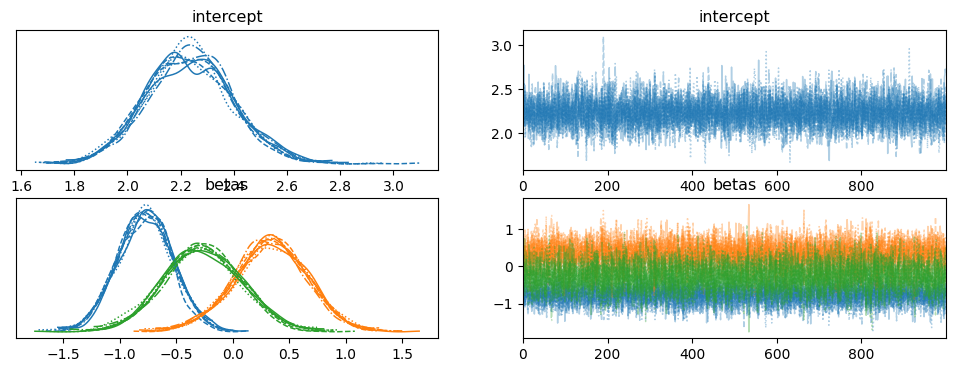

In [138]:
with simple_model:
    trace = pm.sample(cores=8, target_accept=0.9)

az.plot_trace(trace, var_names=["intercept", "betas"])
az.summary(trace, var_names=["intercept", "betas"])

In [139]:
np.exp(
    np.dot(
        scaled_data_df.values[prep_df.y.isnull()],
        trace.posterior.betas.values.reshape(-1, 3).mean(axis=0),
    )
    + trace.posterior.intercept.values.reshape(-1).mean(axis=0)
)

array([ 9.07839739, 17.00554235, 13.4438902 ,  7.96299481, 10.86382116,
       13.17492317,  7.54185049, 10.79601548,  8.06373757,  7.96878274,
        9.61177119,  4.24646442, 18.65957805,  8.7537911 ,  3.32795439,
       20.07005933, 21.12853835, 22.58189513,  9.39175621,  5.50535823,
       19.2378718 , 21.28019329, 22.14683018,  2.35749411,  5.6338349 ,
        4.44219686, 21.33271541,  2.77119699,  3.41187987,  5.15414469,
        4.30664972, 17.3175623 ,  7.73148453,  5.75998987, 15.32433031,
        9.89242967,  3.93476386,  4.68416822, 13.19552238,  9.29290673,
        4.30807459,  3.37748061,  5.52594365, 15.06865381,  7.61187672,
        7.27569422, 15.13853142])

In [140]:
with simple_model:
    pm.set_data(
        {"X": scaled_data_df.values, "observed": np.ma.masked_invalid(prep_df.y.values)}
    )
    ppc = pm.sample_posterior_predictive(trace, predictions=True)

az.summary(ppc)

Sampling: [betas, y]


ValueError: n too large or p too small, see Generator.negative_binomial Notes
Apply node that caused the error: nbinom_rv{0, (0, 0), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F7DE6491A80>), MakeVector{dtype='int64'}.0, TensorConstant{4}, alpha, Elemwise{Composite{(i0 / (exp((i1 + i2)) + i0))}}[(0, 2)].0)
Toposort index: 11
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, ()), TensorType(float64, (None,))]
Inputs shapes: ['No shapes', (1,), (), (), (108,)]
Inputs strides: ['No strides', (8,), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7F7DE6491A80, array([108]), array(4), array(0.81646759), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
with pm.Model() as car_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    adjacency_idx = pm.MutableData("adjacency_idx", model_df.index.values)
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)
    X = pm.MutableData("X", model_df[data_cols].values.astype(np.float64))

    betas = pm.Normal("betas", mu=0, tau=1e-5, shape=X.shape[1] + 1)

    # spatial adjustments, random effects
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-5, alpha=alpha, W=W)

    mu = pm.Deterministic(
        "mu",
        pm.math.exp(
            betas[0]
            + pm.math.dot(X, betas[1:])
            + phi[adjacency_idx]
            + pm.math.log(total_pixels)
        ),
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(car_model)

In [ ]:
with simple_model:
    trace = pm.sample(2000, tune=2000, cores=8, target_accept=0.9, tree_depth=15)

az.plot_trace(trace, var_names=["betas", "phi"])
az.summary(trace, var_names=["betas", "phi"])